source: https://www.kaggle.com/code/melihkacaman/dog-vs-cat-using-logistic-regression/notebook

# Imports

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
# Filter Warnings
warnings.filterwarnings('ignore')

from PIL import Image
import os

#from sklearnex import patch_sklearn
#patch_sklearn()


# Constants 

In [2]:
base_dir = '/Users/leonjye/Downloads/CatAndDog'
PATH_TRAIN_CAT = base_dir + '/training_set/cats'
PATH_TRAIN_DOG = base_dir + '/training_set/dogs'
PATH_TEST_CAT = base_dir + '/test_set/cats'
PATH_TEST_DOG = base_dir + '/test_set/dogs'

CAT = 1
DOG = 0

IMG_WIDTH = 200
IMG_HEIGHT = 200
NR_PIX = IMG_HEIGHT * IMG_WIDTH
NR_CHANELS = 3
NR_FEATURES = NR_PIX * NR_CHANELS

In [8]:
def load_data_asanarray(path):
    data = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            specific_path = os.path.join(dirname, filename)
            if not specific_path.endswith('.jpg'):
                continue
            image = Image.open(specific_path).resize((200,200))
            img_array = np.asarray(image)
            data.append(img_array)
    return np.asarray(data).reshape(len(data),IMG_WIDTH, IMG_HEIGHT, NR_CHANELS)

# Data Pre-processing

In [9]:
%%time
data_train_cat = load_data_asanarray(PATH_TRAIN_CAT)
data_train_dog = load_data_asanarray(PATH_TRAIN_DOG)
#print(f'data_train_cat size is {len(data_train_cat)} data_train_dog size is {len(data_train_dog)}')

CPU times: user 13.7 s, sys: 774 ms, total: 14.5 s
Wall time: 15.4 s


In [10]:
y_label_cat = np.ones((len(data_train_cat),1))
y_label_dog = np.zeros((len(data_train_dog),1))

In [11]:
x_train = np.concatenate((data_train_cat, data_train_dog), axis=0)
y_train = np.concatenate((y_label_cat, y_label_dog), axis=0)

In [12]:
%%time
data_test_cat = load_data_asanarray(PATH_TEST_CAT)
data_test_dog = load_data_asanarray(PATH_TEST_DOG)
print(f'data_train_cat size is {len(data_train_cat)} data_train_dog size is {len(data_train_dog)}')

data_train_cat size is 4000 data_train_dog size is 4000
CPU times: user 3.47 s, sys: 486 ms, total: 3.95 s
Wall time: 4.5 s


In [13]:
y_label_cat = np.ones((len(data_test_cat),1))
y_label_dog = np.zeros((len(data_test_dog),1))
x_test = np.concatenate((data_test_cat, data_test_dog), axis=0)
y_test = np.concatenate((y_label_cat, y_label_dog), axis=0)
print(f'x_test shape is {x_test.shape} and y_shape is {y_test.shape}')

x_test shape is (2000, 200, 200, 3) and y_shape is (2000, 1)


## Shuffling Data
* Our data is seperetad from each other in their folders, but I want to shuffle them 
* so we need to concatenate all together and after this, we can use train_test_split function from sklearn 

In [14]:
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

x_train,x_test,y_train, y_test = train_test_split(X,Y, test_size=0.15, random_state=45)

In [15]:
print(x_train.shape, y_train.shape)

(8500, 200, 200, 3) (8500, 1)


In [16]:
print(x_test.shape, y_test.shape)

(1500, 200, 200, 3) (1500, 1)


## Reshape For Traning And T 
* Now, we have 3d array for our X's and have 2d array our test.
* We need 2d array for training proccess, in this case we have already 2d array for test datasets
* So we need to reshape our train sets

In [17]:
x_train = x_train.reshape(len(x_train), NR_FEATURES).T
x_test = x_test.reshape(len(x_test), NR_FEATURES).T

In [18]:
y_train = y_train.T
y_test = y_test.T

In [19]:
print(x_train.shape, y_train.shape)

(120000, 8500) (1, 8500)


In [20]:
print(x_test.shape, y_test.shape)

(120000, 1500) (1, 1500)


# Logistic Regression 
**we should initialize our first weights and bias**

In [21]:
def init_param(dimension):
    w = np.full((dimension,1), 0.01)
    b = 0.0

    return w,b

In [22]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))     # Define sigmoid function
    sig = np.minimum(sig, 0.9999)  # Set upper bound
    sig = np.maximum(sig, 0.0001)  # Set lower bound
    return sig

In [23]:
x_train, x_test = x_train / 255, x_test/ 255

In [24]:
def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)

    loss = -y_train * np.log(y_head) - (1-y_train) * np.log(1-y_head)
    cost = (np.sum(loss)) / x_train.shape[1]
    return cost

In [25]:
def forward_and_backward_propagation(w,b,x_train, y_train):
    z = np.dot(w.T, x_train) + b
    y_head = sigmoid(z)

    loss = -y_train * np.log(y_head) - (1-y_train) * np.log(1-y_head)
    cost = (np.sum(loss)) / x_train.shape[1]

    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]

    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}

    return cost, gradients

In [26]:
def train(w,b,x_train,y_train,learning_rate, nr_iteration):
    cost_list = []
    cost_list2 = []
    index = []

    for i in range(nr_iteration):
        cost, gradients = forward_and_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)

        w = w - learning_rate * gradients['derivative_weight']
        b = b - learning_rate * gradients['derivative_bias']

        if i%10 == 0 :
            cost_list2.append(cost)
            index.append(i)
            print("Cost after iteration %i: %f" %(i, cost))


    parameters = {'weight': w, 'bias': b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()

    return parameters, gradients,cost_list

In [27]:
def predict(w,b,x_test):
    z = sigmoid(np.dot(w.T, x_test)+b)
    y_predict = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i] <= 0.5:
            y_predict[0,i] = 0
        else :
            y_predict[0,i] = 1

    return y_predict


Cost after iteration 0: 4.590050
Cost after iteration 10: 4.590050
Cost after iteration 20: 4.590050
Cost after iteration 30: 4.590050
Cost after iteration 40: 4.589546
Cost after iteration 50: 2.636357
Cost after iteration 60: 2.666693
Cost after iteration 70: 2.677974
Cost after iteration 80: 2.681398
Cost after iteration 90: 2.680789
Cost after iteration 100: 2.678615
Cost after iteration 110: 2.675542
Cost after iteration 120: 2.671580
Cost after iteration 130: 2.667067
Cost after iteration 140: 2.661896
Cost after iteration 150: 2.656202
Cost after iteration 160: 2.650095
Cost after iteration 170: 2.643923
Cost after iteration 180: 2.637767
Cost after iteration 190: 2.631748


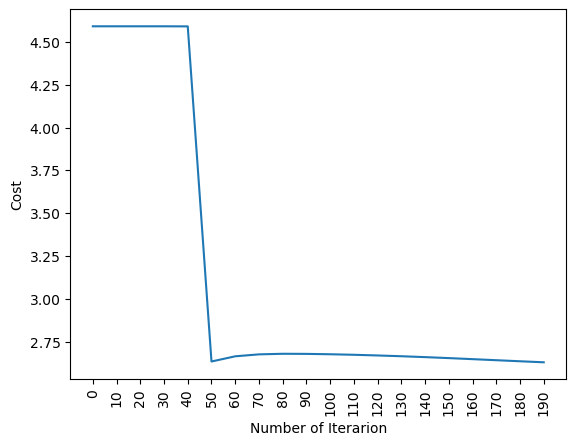

[[1. 1. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]]
train accuracy: 0.0 %
test accuracy: 0.0 %


In [29]:
def logistic_regression(x_train, y_train,x_test, y_test,learning_rate,num_of_iterarion):
    dimension = x_train.shape[0]
    w,b = init_param(dimension)

    parameters, gradients, cost_list = train(w,b,x_train,y_train, learning_rate,num_of_iterarion)

    y_prediction_test = predict(parameters['weight'], parameters['bias'], x_test)
    y_prediction_train = predict(parameters['weight'], parameters['bias'], x_train)

    print(y_train, y_prediction_train)
     # Print train/test Errors
    from sklearn.metrics import accuracy_score
    print(f"train accuracy: {accuracy_score(y_train, y_prediction_train)*100} %")
    print(f"test accuracy: {accuracy_score(y_test, y_prediction_test)*100} %")

logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.001, num_of_iterarion = 200)
